# El ecosistema JuMP para optimización matemática

##  Ejemplo de motivación: Número mínimo de pasaportes necesarios para visitar todos los países sin necesidad de VISA.

Utilizamos los datos provenientes de https://www.passportindex.org/. "Become a global citizen".

In [1]:
#;git clone https://github.com/ilyankou/passport-index-dataset.git

In [2]:
using DelimitedFiles
data = readdlm(joinpath("passport-index-dataset\\legacy\\2019-11-23","passport-index-matrix.csv"),',')
cntr = data[2:end,1]
vf = (x ->  x == -1 || x == 3 ? 1 : 0).(data[2:end,2:end])

199×199 Array{Int64,2}:
 1  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  1  0  1  0  1  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  1  0  1  1  1  0  1  0  1  0     1  1  0  1  1  1  1  1  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  1
 0  1  0  1  0  1  0  0  0  1  0  1  0  …  0  1  0  0  0  1  1  1  0  0  1  1
 0  1  0  1  0  1  1  1  0  1  0  1  0     1  1  0  1  1  1  1  1  0  0  0  0
 0  1  0  0  0  1  1  1  0  0  0  1  0     0  0  0  1  1  0  0  0  0  0  0  0
 0  1  0  1  0  1  1  1  1  1  0  1  0     1  1  0  1  1  1  1  1  0  0  0  0
 0  1  0  1  0  1  1  1  0  1  0  1  0     1  1  0  1  1  1  1  1  0  0  0  0
 0  1  0  0  0  1  0  0  0  0  1  1  0  …  0  0  0  0  1  1  0  0  0  0  0  0
 0  1  0  1  0  1  0  0  0  1  0  1  0     1  1  1  1  0  1  1  0  0  0  1  1
 0  0  0  0  0  0  0  0  0  0  0  1  1  

### (Constrained) Mathematical Optimization and JuMP

$$ \begin{align*} \min_{x,y} &&\quad \sum_{\operatorname{cntr} \;\in\; \operatorname{World}} \operatorname{pass}_{\,\operatorname{cntr}} \\ \text{s.t.}&&\quad \sum_{\operatorname{cntr} \;\in\; \operatorname{World}}\operatorname{vf}(\operatorname{cntr},\operatorname{dst}) \cdot \operatorname{pass}_{\,\operatorname{cntr}} &\geq 1\quad &\quad& \forall \; \operatorname{dst} \;\in \; \operatorname{World}\\ &&\operatorname{pass}_{\,\operatorname{cntr}} &\in \{0,1\}&\quad& \forall \; \operatorname{cntr}\in \; \operatorname{World}. \end{align*} $$

In [3]:
using JuMP, GLPK
model = Model(with_optimizer(GLPK.Optimizer))
@variable(model, pass[1:length(cntr)], Bin)
@constraint(model, [j=1:length(cntr)], sum( vf[i,j]*pass[i] for i in 1:length(cntr)) >= 1)
@objective(model, Min, sum(pass))
JuMP.optimize!(model)
print(JuMP.objective_value(model)," passports: ",join(cntr[findall(JuMP.value.(pass) .== 1)],", "))

24.0 passports: Afghanistan, Angola, Australia, Austria, China, Comoros, Congo, Eritrea, Gambia, Georgia, Hong Kong, India, Iraq, Kenya, Madagascar, Maldives, North Korea, Papua New Guinea, Seychelles, Singapore, Somalia, Tunisia, United Arab Emirates, United States

## Ejemplo paso a paso: Resolviendo un Problema Lineal

Resolvamos el siguiente problema lineal de 2 variables

$$
\begin{align*}
\max_{x,y} \quad x + 2y \\
\text{s.t.} \quad x + y\leq 1 \\
0\leq x, y \leq 1
\end{align*}
$$

Cargamos JuMP, MathOptInterface (MOI) y GLPK (GNU LP/MIP solver -gratuito-):

In [4]:
using JuMP  
using MathOptInterface # Replaces MathProgBase
# shortcuts
const MOI = MathOptInterface
const MOIU = MathOptInterface.Utilities
using GLPK # Loading the GLPK module for using its solver

Construir un objeto tipo modelo (que contiene variables, restricciones, opciones del solver, etc):

In [5]:
model = Model(with_optimizer(GLPK.Optimizer,msg_lev = 4));

Definir las variables del modelo $0\leq x, y \leq 1$:

In [6]:
@variable(model, 0 <= x <= 1)
@variable(model, 0 <= y <= 1)

y

Añadir restricción al modelo $x + y \leq 1$:

In [7]:
@constraint(model, x + y <= 1)

x + y <= 1.0

Añadir función objetivo al modelo $\max x + 2y$:

In [8]:
@objective(model, Max, x + 2y)

x + 2 y

Veamos cómo está quedando el modelo

In [9]:
model

A JuMP Model
Maximization problem with:
Variables: 2
Objective function type: GenericAffExpr{Float64,VariableRef}
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK
Names registered in the model: x, y

El modelo está completo y ya hemos seleccionado un solver al comienzo. Solo queda llamar a la función `Optimize` para resolverlo

In [10]:
JuMP.optimize!(model)

GLPK Simplex Optimizer, v4.64
1 row, 2 columns, 2 non-zeros
*     0: obj = -0.000000000e+000 inf =  0.000e+000 (2)
*     2: obj =  2.000000000e+000 inf =  0.000e+000 (0)
OPTIMAL LP SOLUTION FOUND


Podemos chequear el estado de la optimización:
- ¿Obtuvimos valores óptimos para el primal?
- ¿Se terminó el problema?
- ¿Obtuvimos un punto factible?
- ¿Qué pasa con el Dual?

In [11]:
@show JuMP.has_values(model)
@show JuMP.termination_status(model) == MOI.OPTIMAL
@show JuMP.primal_status(model) == MOI.FEASIBLE_POINT
@show JuMP.dual_status(model) == MOI.FEASIBLE_POINT

JuMP.has_values(model) = true
JuMP.termination_status(model) == MOI.OPTIMAL = true
JuMP.primal_status(model) == MOI.FEASIBLE_POINT = true
JuMP.dual_status(model) == MOI.FEASIBLE_POINT = true


true

In [12]:
display(typeof(MOI.FEASIBLE_POINT))

Enum MathOptInterface.ResultStatusCode:
NO_SOLUTION = 0
FEASIBLE_POINT = 1
NEARLY_FEASIBLE_POINT = 2
INFEASIBLE_POINT = 3
INFEASIBILITY_CERTIFICATE = 4
NEARLY_INFEASIBILITY_CERTIFICATE = 5
REDUCTION_CERTIFICATE = 6
NEARLY_REDUCTION_CERTIFICATE = 7
UNKNOWN_RESULT_STATUS = 8
OTHER_RESULT_STATUS = 9

Recuperemos los valores que nos importan

In [13]:
@show JuMP.value(x)              # Old syntax: getvalue(x)
@show JuMP.value(y)              # Old syntax: getvalue(y)
@show JuMP.objective_value(model);       # Old syntax: getobjectivevalue(model)

JuMP.value(x) = 0.0
JuMP.value(y) = 1.0
JuMP.objective_value(model) = 2.0


Podemos también ponerle nombre a alguna restricción para llamarla más adelante (o pedir calcular su multiplicador, eliminarla, etc)

In [14]:
model = Model(with_optimizer(GLPK.Optimizer, msg_lev = 0))
@variable(model, 0 <= x <= 1)
@variable(model, 0 <= y <= 1)
@constraint(model, inequality, x + y <= 1)     # <=============== constraint can be referenced later as "inequality"
@objective(model, Max, x + 2y)
JuMP.optimize!(model)
@show JuMP.termination_status(model) == MOI.OPTIMAL

JuMP.termination_status(model) == MOI.OPTIMAL = true


true

In [15]:
λ = JuMP.dual(inequality)

-1.0

In [16]:
JuMP.delete(model, inequality)
JuMP.optimize!(model)
@show JuMP.termination_status(model) == MOI.OPTIMAL
@show JuMP.objective_value(model);

JuMP.termination_status(model) == MOI.OPTIMAL = true
JuMP.objective_value(model) = 3.0


# Restricciones no lineales

In [17]:
using Ipopt

model = Model(with_optimizer(Ipopt.Optimizer))
@variable(model, x)
@variable(model, y)

@NLobjective(model, Min, (1-x)^2 + 100(y-x^2)^2)
@NLconstraint(model, exp(x)+sin(x) <=0)

JuMP.optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:        4

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

# Optimización Cónica (Otro tipo de restricciones)

¿Por qué Optimización Cónica?
- Dualidad similar al caso de programación lineal.
- Algoritmos más rápidos y estables
    - Se evitan problemas con no diferenciabilidad, se explota la forma dual-primal, teoría fuerte en barreras y métodos de punto interior.
    - Cambios en la industria en el 2018:
        1. Knitro versión 11.0 añade soporte para restricciones SOCP.
        2. Mosek version 9.0 desecha expresiones y formulaciones basadas en funciones por formulaciones puramente cónicas (lineal, SOCP, SOCP rotado, SDP, exp,etc)

## Optimización Cónica

Los problemas de programación cónica son problemas de optimización convexos en los cuales la función objetivo es minimizazda sobre la intersección de subespacios afines y conos convexos. Un ejemplo de formulación cónica de un problema es:

\begin{equation}
\min_{ x \in \mathbb{R}^n} a_0 ^\top x + b_0
\end{equation}

tal que:
$$A_i x + b_i \in \mathcal{C}_i  \quad \text{for } i = 1 \dotso m$$

El problema dual correspondiente es:

$$ \max_{y_1, \dotso , y_m} - \sum_{i = 1}^{m} b_i ^T y_i + b_0$$

tal que:
$$ a_0 - \sum_{i = 1}^{m} A_{i}^{T} y_{i} = 0 $$
$$ y_i \in \mathcal{C}_i^*$$

Donde cada $\mathcal{C}_i$ es un cono cerrado convexo y $\mathcal{C}_i^*$ es el cono dual.

### Cono de Segundo Orden

El Cono de Segundo Orden (o Cono de Lorentz) de dimensión $n$ es de la forma:

$$ Q^n = \{ (t,x) \in \mathbb{R}^n: t \ge \lVert x \rVert_2 \} $$

Un Cono de Segundo Orden rotado en $\pi/4$ en el plano  $(x_1,x_2)$ es llamado 
Cono de Segundo Orden Rotado y es de la forma:

$$ Q^n_r = \{ (t,u,x) \in \mathbb{R}^n: 2tu \ge \lVert x \rVert_2, t, u \ge 0 \} $$


Estos conos se representan en `JuMP` usando conjuntos `MOI`, `SecondOrderCone` y `RotatedSecondOrderCone`

#### Ejemplo: Proyección Euclideana en un Hiperplano

Para un punto dado $u_0$ y un conjunto $K$, nos referiamos al punto $u \in K$ que es lo más cercano a $u_0$ como la proyección de $u_0$ en $K$. La proyección de $u_0$ en un hiperplano $K = \{ u : p'\cdot u = q \}$ está dado por:

$$ \begin{align}
& \displaystyle\min_{x \in \mathbb{R}^n} & \lVert u - u_0 \rVert \\\\
& \text{s.t. } & p'\cdot u = q 
\end{align}$$

Podemos modelar esto como un problema de optimización cónica:

$$ \begin{align}
& \displaystyle\min & t \\\\
& \text{s.t. } & p'\cdot u = q \\\\
&  \quad & (t, u - u_0) \in Q^{n+1}
\end{align}$$

Si lo transformamos identificando cada uno de los términos,

$$ \begin{align}
x & = (t,u)\\\\
a_0 & = e_1\\\\
b_0 & = 0\\\\
A_1 & =(0,p)\\\\
b_1 & = -q \\\\
C_1 & = \mathbb{R}\\\\
A_2 & = 1\\\\
b_2 &= -(0,u_0)\\\\
C_2 &= Q^{n+1}
\end{align}$$

Entonces, el problema dual está dado por:

$$ \begin{align}
& \displaystyle\max & y_1 + (0,u_0)^\top y_2 \\\\
& \text{s.t. } & e_1 -(0,p)^\top y_1 - y_2 = 0 \\\\
&  \quad & y_1 \in \mathbb{R}\\\\
& \quad & y_2 \in Q^{n+1}
\end{align}$$

En primer lugar, cargamos los paquetes `JuMP`, `LinearAlgebra`, `Random` y el solver `ECOS`.

In [18]:
using JuMP
using ECOS
using LinearAlgebra
using Random
Random.seed!(2020);

Démosno algunos valores aleatorios para los inputs: $u_0$, $p$ y $q$

In [19]:
u0 = rand(10)
p = rand(10)
q = rand();

Podemos escribir el modelo como:

In [20]:
model = Model(optimizer_with_attributes(ECOS.Optimizer, "printlevel" => 0))
@variable(model, u[1:10])
@variable(model, t)
@objective(model, Min, t)
@constraint(model, [t, (u - u0)...] in SecondOrderCone())
@constraint(model, u' * p == q)
optimize!(model)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+01  4e-01  3e-04  1e+00  6e+00    ---    ---    1  1  - |  -  - 
 1  +3.134e-01  +3.200e-01  +1e+00  6e-02  3e-05  1e-01  7e-01  0.8932  1e-03   2  1  2 |  0  0
 2  +1.376e+00  +1.404e+00  +7e-02  5e-03  2e-06  4e-02  5e-02  0.9690  5e-02   2  2  2 |  0  0
 3  +1.415e+00  +1.415e+00  +8e-04  6e-05  2e-08  4e-04  6e-04  0.9890  1e-04   1  1  1 |  0  0
 4  +1.415e+00  +1.415e+00  +9e-06  6e-07  2e-10  5e-06  7e-06  0.9890  1e-04   1  1  1 |  0  0
 5  +1.415e+00  +1.415e+00  +1e-07  7e-09  2e-12  5e-08  7e-08  0.9890  1e-04   1  1  1 |  0  0
 6  +1.415e+00  +1.415e+00  +1e-09  8e-11  3e-14  6e-10  8e-10  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=7.5e-11, reltol=7.4e-10, abstol=1.1e-09).
Runtime: 0.000138 seconds.



In [21]:
@show objective_value(model);
@show value.(u);

objective_value(model) = 1.4149915748070703
value.(u) = [0.03080667950164791, 0.5687503071622262, 0.4982756380955075, 0.32732944869183017, 0.5755950055187378, 0.117335178956295, 0.021419168446740567, 0.5510291353919837, -0.24224068275971017, 0.053604926321581634]


El problema dual se puede calcular como:

In [22]:
e1 = [1.0, zeros(10)...]
dual_model = Model(optimizer_with_attributes(ECOS.Optimizer, "printlevel" => 0))
@variable(dual_model, y1 <= 0.0)
@variable(dual_model, y2[1:11])
@objective(dual_model, Max, q * y1 + dot(vcat(0.0, u0), y2))
@constraint(dual_model, e1 - [0.0, p...] .* y1 - y2 .== 0.0)
@constraint(dual_model, y2 in SecondOrderCone())
optimize!(dual_model)


ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +5e+00  4e-01  4e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -8.629e+00  -2.721e+00  +5e-01  4e-01  4e-01  7e+00  2e-01  0.8934  1e-03   2  1  1 |  0  0
 2  -2.387e+00  -2.455e+00  +2e-01  9e-02  5e-02  4e-02  5e-02  0.7977  5e-02   2  2  2 |  0  0
 3  -1.467e+00  -1.426e+00  +8e-03  5e-03  2e-03  5e-02  5e-03  0.9655  7e-02   2  2  2 |  0  0
 4  -1.416e+00  -1.415e+00  +9e-05  5e-05  3e-05  5e-04  6e-05  0.9890  1e-04   2  1  1 |  0  0
 5  -1.415e+00  -1.415e+00  +1e-06  6e-07  3e-07  6e-06  7e-07  0.9890  1e-04   2  1  1 |  0  0
 6  -1.415e+00  -1.415e+00  +1e-08  7e-09  3e-09  6e-08  7e-09  0.9890  1e-04   3  1  1 |  0  0

OPTIMAL (within feastol=6.7e-09, reltol=8.1e-09, abstol=1.1e-08).
Runtime: 0.000123 seconds.



In [23]:
@show objective_value(dual_model);

objective_value(dual_model) = 1.4149916455792486


Para ver más sobre el tema: [Click aquí](https://danpereda.github.io/post/conicopt/)

# Rocket Control

This tutorial shows how to solve a nonlinear rocketry control problem. The problem was drawn from the COPS3 benchmark.

Our goal is to maximize the final altitude of a vertically launched rocket. We can control the thrust of the rocket, and must take account of the rocket mass, fuel consumption rate, gravity, and aerodynamic drag.

Let us consider the basic description of the model (for the full description, including parameters for the rocket, see the COPS3 PDF)

## Overview
We will use a discretized model of time, with a fixed number of time steps, n. We will make the time step size $\Delta t$, and thus the final time $t_f = n⋅\Delta t$, a variable in the problem. To approximate the derivatives in the problem we will use the trapezoidal rule.

### State and Control ,

We will have three state variables:

- Velocity, $v$
- Altitude, $h$
- Mass of rocket and remaining fuel, $m$

and a single control variable, thrust $T$. Our goal is thus to maximize $h(t_f)$. Each of these corresponds to a JuMP variable indexed by the time step.

### Dynamics
We have three equations that control the dynamics of the rocket:

Rate of ascent:
$$ h' = v$$
Acceleration:
$$ v' = \displaystyle\frac{T-D(h,v)}{m} - g(h)$$
Rate of mass loss:
$$ m' = -\frac{T}{c}  $$
Where drag $D(h,v)$ is a function of altitude and velocity, and gravity $g(h)$ is a function of altitude.

These forces are defined as:

$$ D(h,v) =\displaystyle D_c v^2 \exp\left(-h_c\left(\frac{h-h(0)}{h(0)}\right)\right)$$

and

$$ g(h) = g_0\left(\frac{h(0)}{h}\right)^2$$

The three rate equations correspond to JuMP constraints, and for convenience we will represent the forces with nonlinear expressions.

In [24]:
using JuMP, Ipopt

# Create JuMP model, using Ipopt as the solver
rocket = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 0))

# Constants
# Note that all parameters in the model have been normalized
# to be dimensionless. See the COPS3 paper for more info.
h_0 = 1    # Initial height
v_0 = 0    # Initial velocity
m_0 = 1    # Initial mass
g_0 = 1    # Gravity at the surface

T_c = 3.5  # Used for thrust
h_c = 500  # Used for drag
v_c = 620  # Used for drag
m_c = 0.6  # Fraction of initial mass left at end

c     = 0.5 * sqrt(g_0 * h_0)  # Thrust-to-fuel mass
m_f   = m_c * m_0            # Final mass
D_c   = 0.5 * v_c * m_0 / g_0    # Drag scaling
T_max = T_c * g_0 * m_0        # Maximum thrust

n = 800   # Time steps

@variables(rocket, begin
    Δt ≥ 0, (start = 1/n) # Time step
    # State variables
    v[1:n] ≥ 0            # Velocity
    h[1:n] ≥ h_0          # Height
    m_f ≤ m[1:n] ≤ m_0    # Mass
    # Control
    0 ≤ T[1:n] ≤ T_max    # Thrust
end)

# Objective: maximize altitude at end of time of flight
@objective(rocket, Max, h[n])

# Initial conditions
@constraints(rocket, begin
    v[1] == v_0
    h[1] == h_0
    m[1] == m_0
    m[n] == m_f
end)

# Forces
# Drag(h,v) = Dc v^2 exp( -hc * (h - h0) / h0 )
@NLexpression(rocket, drag[j = 1:n], D_c * (v[j]^2) * exp(-h_c * (h[j] - h_0) / h_0))
# Grav(h)   = go * (h0 / h)^2
@NLexpression(rocket, grav[j = 1:n], g_0 * (h_0 / h[j])^2)
# Time of flight
@NLexpression(rocket, t_f, Δt * n)

# Dynamics
for j in 2:n
    # h' = v
    
    # Rectangular integration
    # @NLconstraint(rocket, h[j] == h[j - 1] + Δt * v[j - 1])
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        h[j] == h[j - 1] + 0.5 * Δt * (v[j] + v[j - 1]))

    # v' = (T-D(h,v))/m - g(h)
    
    # Rectangular integration
    # @NLconstraint(rocket, v[j] == v[j - 1] + Δt *(
    #                 (T[j - 1] - drag[j - 1]) / m[j - 1] - grav[j - 1]))
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        v[j] == v[j-1] + 0.5 * Δt * (
            (T[j] - drag[j] - m[j] * grav[j]) / m[j] +
            (T[j - 1] - drag[j - 1] - m[j - 1] * grav[j - 1]) / m[j - 1]))

    # m' = -T/c

    # Rectangular integration
    # @NLconstraint(rocket, m[j] == m[j - 1] - Δt * T[j - 1] / c)
    
    # Trapezoidal integration
    @NLconstraint(rocket,
        m[j] == m[j - 1] - 0.5 * Δt * (T[j] + T[j-1]) / c)
end

# Solve for the control and state
println("Solving...")
status = optimize!(rocket)

# Display results
# println("Solver status: ", status)
println("Max height: ", objective_value(rocket))

Solving...
Max height: 1.0128340648308058


In [25]:
#import Pkg
#Pkg.add("Gadfly")

In [26]:
# Can visualize the state and control variables
using Gadfly

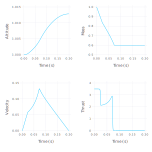

In [27]:
h_plot = plot(x = (1:n) * value.(Δt), y = value.(h)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Altitude"))
m_plot = plot(x = (1:n) * value.(Δt), y = value.(m)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Mass"))
v_plot = plot(x = (1:n) * value.(Δt), y = value.(v)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Velocity"))
T_plot = plot(x = (1:n) * value.(Δt), y = value.(T)[:], Geom.line,
                Guide.xlabel("Time (s)"), Guide.ylabel("Thrust"))
draw(SVG(6inch, 6inch), vstack(hstack(h_plot, m_plot), hstack(v_plot, T_plot)))

# Ejercicio: Sudoku

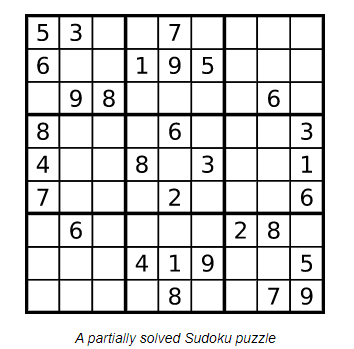

Sudoku is a popular number puzzle. The goal is to place the digits 1,...,9 on a nine-by-nine grid, with some of the digits already filled in. Your solution must satisfy the following rules:

- The numbers 1 to 9 must appear in each 3x3 square
- The numbers 1 to 9 must appear in each row
- The numbers 1 to 9 must appear in each column

This isn't an optimization problem, its actually a feasibility problem: we wish to find a feasible solution that satsifies these rules. You can think of it as an optimization problem with an objective of 0.

We can model this problem using 0-1 integer programming: a problem where all the decision variables are binary. We'll use JuMP to create the model, and then we can solve it with any integer programming solver.

In [28]:
using GLPK

We will define a binary variable (a variable that is either $0$ or $1$) for each possible number in each possible cell. The meaning of each variable is as follows:

$x[i,j,k] = 1$ if and only if cell $(i,j)$ has number $k$

where `i` is the row and `j` is the colum

In [29]:
# Create a model
sudoku = Model(GLPK.Optimizer)

# Create our variables
@variable(sudoku, x[i=1:9, j=1:9, k=1:9], Bin);

Now we can begin to add our constraints. We'll actually start with something obvious to us as humans, but what we need to enforce: that there can be only one number per cell.

In [30]:
for i = 1:9, j = 1:9  # Each row and each column
    # Sum across all the possible digits
    # One and only one of the digits can be in this cell, 
    # so the sum must be equal to one
    @constraint(sudoku, sum(x[i,j,k] for k in 1:9) == 1)
end

Next we'll add the constraints for the rows and the columns. These constraints are all very similar, so much so that we can actually add them at the same time.

In [31]:
for ind = 1:9  # Each row, OR each column
    for k = 1:9  # Each digit
        # Sum across columns (j) - row constraint
        @constraint(sudoku, sum(x[ind,j,k] for j in 1:9) == 1)
        # Sum across rows (i) - column constraint
            @constraint(sudoku, sum(x[i,ind,k] for i in 1:9) == 1)
    end
end

Finally, we have the to enforce the constraint that each digit appears once in each of the nine 3x3 sub-grids. Our strategy will be to index over the top-left corners of each 3x3 square with for loops, then sum over the squares.

In [32]:
for i = 1:3:7, j = 1:3:7, k = 1:9
    # i is the top left row, j is the top left column
    # We'll sum from i to i+2, e.g. i=4, r=4, 5, 6
    @constraint(sudoku, sum(x[r,c,k] for  r in i:i+2, c in j:j+2) == 1)
end

The final step is to add the initial solution as a set of constraints. We'll solve the problem that is in the picture at the start of the notebook. We'll put a 0 if there is no digit in that location.

In [33]:
# The given digits
init_sol = [ 5 3 0 0 7 0 0 0 0;
             6 0 0 1 9 5 0 0 0;
             0 9 8 0 0 0 0 6 0;
             8 0 0 0 6 0 0 0 3;
             4 0 0 8 0 3 0 0 1;
             7 0 0 0 2 0 0 0 6;
             0 6 0 0 0 0 2 8 0;
             0 0 0 4 1 9 0 0 5;
             0 0 0 0 8 0 0 7 9]
for i = 1:9, j = 1:9
    # If the space isn't empty
    if init_sol[i,j] != 0
        # Then the corresponding variable for that digit
        # and location must be 1
        @constraint(sudoku, x[i,j,init_sol[i,j]] == 1)
    end
end

In [34]:
# solve problem
optimize!(sudoku)

In [35]:
solve_time(sudoku)

0.015000104904174805

In [36]:
# Extract the values of x
x_val = value.(x)
# Create a matrix to store the solution
sol = zeros(Int,9,9)  # 9x9 matrix of integers
for i in 1:9, j in 1:9, k in 1:9
    # Integer programs are solved as a series of linear programs
    # so the values might not be precisely 0 and 1. We can just
    # round them to the nearest integer to make it easier
    if round(Int,x_val[i,j,k]) == 1
        sol[i,j] = k
    end
end
# Display the solution
sol

9×9 Array{Int64,2}:
 5  3  4  6  7  8  9  1  2
 6  7  2  1  9  5  3  4  8
 1  9  8  3  4  2  5  6  7
 8  5  9  7  6  1  4  2  3
 4  2  6  8  5  3  7  9  1
 7  1  3  9  2  4  8  5  6
 9  6  1  5  3  7  2  8  4
 2  8  7  4  1  9  6  3  5
 3  4  5  2  8  6  1  7  9

Which is the correct solution:

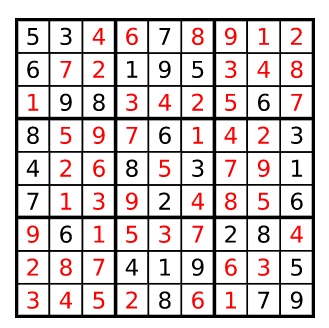